<a href="https://colab.research.google.com/github/TimurMMD/Big-data-UEL-project/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
!pip install -q findspark
!pip install pyspark py4j
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("MyApp").getOrCreate()
spark_bin_path = os.path.join(os.environ["SPARK_HOME"], "bin")

# Check if the spark-submit file exists
spark_submit_path = os.path.join(spark_bin_path, "spark-submit")
if not os.path.exists(spark_submit_path):
    print("Error: spark-submit not found at", spark_submit_path)
    print("Please verify your Spark installation.")
    exit(1)
# Add spark_bin_path to the PATH environment variable
os.environ["PATH"] += os.pathsep + spark_bin_path

# Now try to import and use SparkSession
try:
    from pyspark.sql import SparkSession

    spark = SparkSession.builder.master("local[*]").getOrCreate()
    print("SparkSession created successfully.")
except Exception as e:
    print("Error creating SparkSession:", e)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c8cb620fa2abc11a25c0cc03af972b0a127dc74f1d62c8ed9113bec30d2c08e9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
SparkSession created successfully.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

Bank marketing dataset shows the result of marketing campany of Portuguese Bank. According to data only a small part of was converted to make u new subscription. We need to analyze this dataset and suggest an option to provide better marketing strategy.

In [ ]:
bank = pd.read_csv('/content/dataset.csv')

1. Let's provide EDA. Need to understand what columns are important and what is the correlation between conversion status.

In [ ]:
bank

,occupation,age,education_level,marital_status,communication_channel,call_month,call_day,call_duration,call_frequency,previous_campaign_outcome,conversion_status
0,administrative_staff,28,high_school,married,unidentified,September,9,1,1,successful,not_converted
1,administrative_staff,58,unidentified,married,unidentified,June,5,307,2,unidentified,not_converted
2,jobless,40,high_school,divorced,mobile,February,4,113,1,unidentified,not_converted
3,retired_worker,63,high_school,married,mobile,April,7,72,5,unidentified,not_converted
4,business_owner,43,college,married,landline,July,29,184,4,unidentified,not_converted
...,...,...,...,...,...,...,...,...,...,...,...
45206,administrative_staff,50,high_school,divorced,mobile,May,6,114,1,unsuccessful,not_converted
45207,independent_worker,49,college,married,unidentified,May,13,98,1,unidentified,not_converted
45208,executive,30,college,married,mobile,June,12,175,2,other_outcome,not_converted
45209,retired_worker,59,elementary_school,married,landline,July,15,41,5,unidentified,not_converted


In [ ]:
bank.isnull().sum()

occupation                   0
age                          0
education_level              0
marital_status               0
communication_channel        0
call_month                   0
call_day                     0
call_duration                0
call_frequency               0
previous_campaign_outcome    0
conversion_status            0
dtype: int64

In [ ]:
bank.info()

In [ ]:
bank.duplicated().sum()

6

In [ ]:
bank = bank.drop_duplicates()

In [ ]:
bank1 = bank[(bank['call_duration'] > 0) & (bank['call_duration'] < 500)]

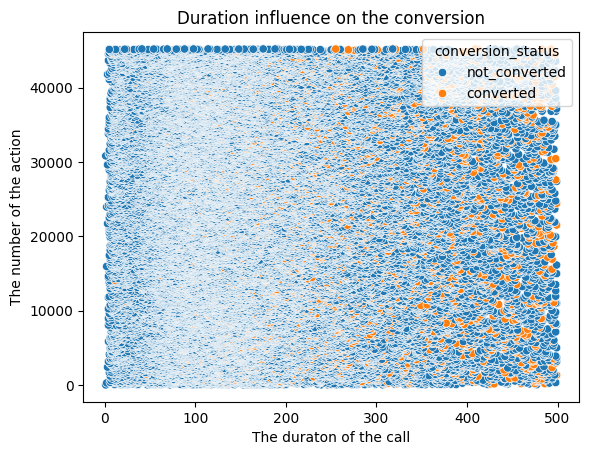

In [ ]:
sns.scatterplot(data=bank1, x='call_duration', y=bank1.index, hue='conversion_status')
plt.xlabel('The duraton of the call')
plt.ylabel('The number of the action')
plt.title('Duration influence on the conversion')
plt.show()

In [ ]:
bank2 = bank[(bank['call_duration'] > 500) & (bank['call_duration'] < 2000)]

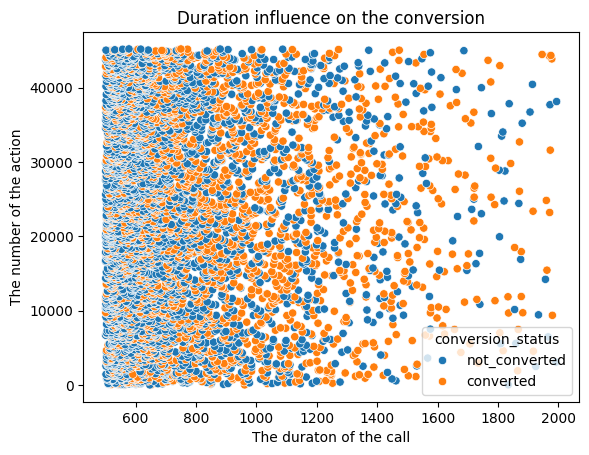

In [ ]:
sns.scatterplot(data=bank2, x='call_duration', y=bank2.index, hue='conversion_status')
plt.xlabel('The duraton of the call')
plt.ylabel('The number of the action')
plt.title('Duration influence on the conversion')
plt.show()

In [ ]:
bank1.conversion_status.value_counts(normalize=True)

conversion_status
not_converted    0.924462
converted        0.075538
Name: proportion, dtype: float64

In [ ]:
bank2.conversion_status.value_counts(normalize=True)

conversion_status
not_converted    0.576995
converted        0.423005
Name: proportion, dtype: float64

In [ ]:
bank3 = bank[(bank['call_duration'] < 3000)]

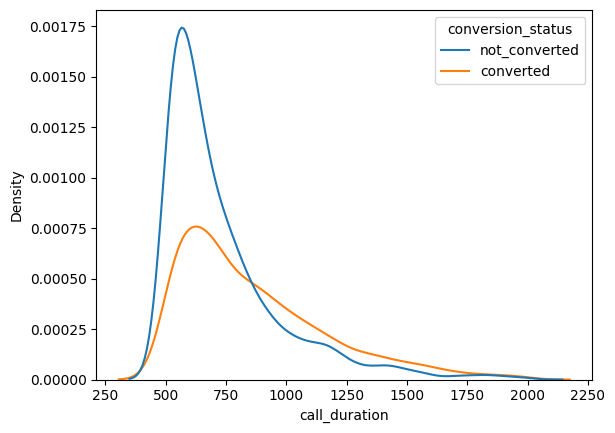

In [ ]:
sns.kdeplot(data=bank2, x='call_duration', hue='conversion_status')
plt.show()

In [ ]:
columns = ['conversion_status','occupation', 'marital_status', 'education_level',
              'communication_channel', 'call_month', 'previous_campaign_outcome']

count_plots = {}

for col in columns:
    count_plots[col + '_ax'] = sns.countplot(x=col, data=bank, palette=sns.color_palette())
    plt.xticks(rotation=90)
    plt.xlabel(col.capitalize().replace('_', ' '))
    plt.ylabel('Count')
    plt.title('Distribution of ' + col.capitalize().replace('_', ' '))
    plt.show()

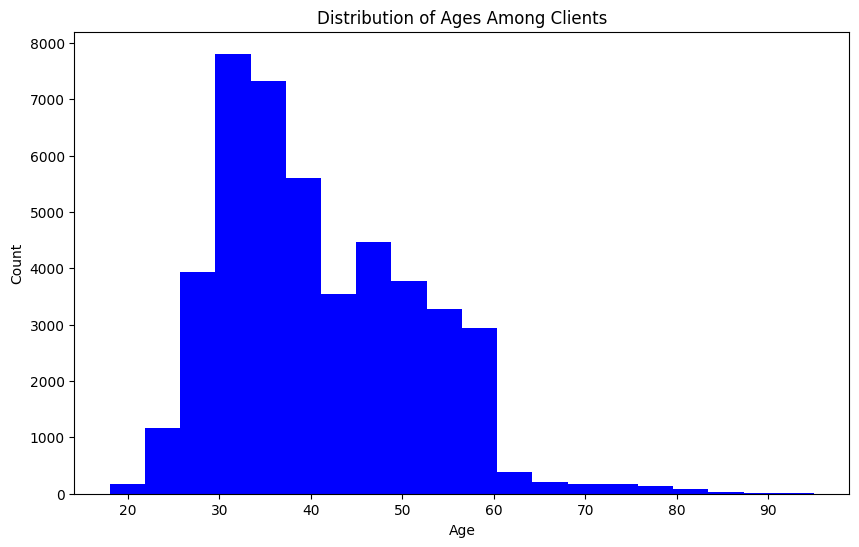

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(bank['age'], bins=20, color='blue')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages Among Clients')
plt.show()

<ipython-input-16-b5ab558b143e>:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data=bank, x='occupation', hue='conversion_status',palette=sns.color_palette())


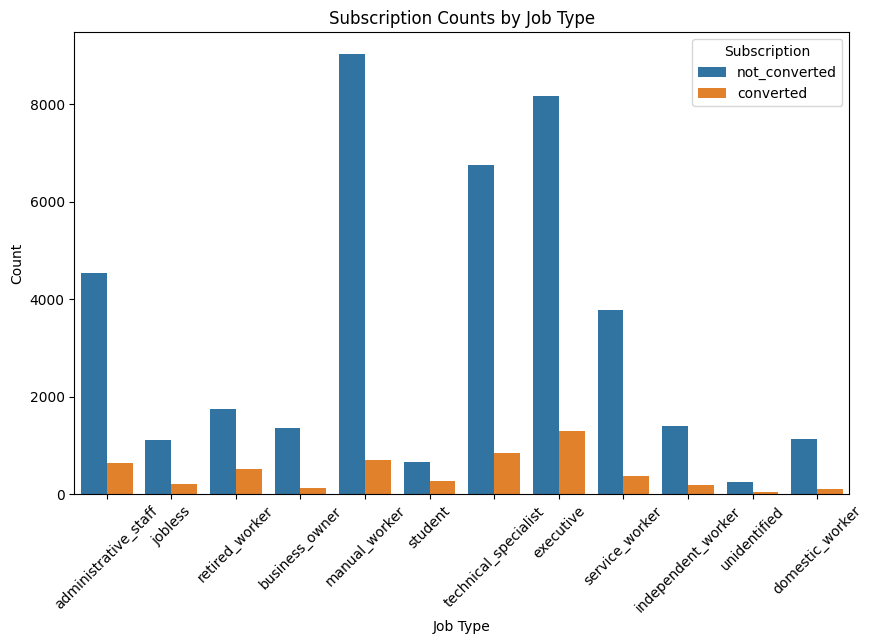

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bank, x='occupation', hue='conversion_status',palette=sns.color_palette())
plt.xlabel('Job Type')
plt.ylabel('Count')
plt.title('Subscription Counts by Job Type')
plt.xticks(rotation=45)
plt.legend(title='Subscription')
plt.show()

<ipython-input-17-0bca33f134f3>:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data=bank, x='education_level', hue='conversion_status',palette=sns.color_palette())


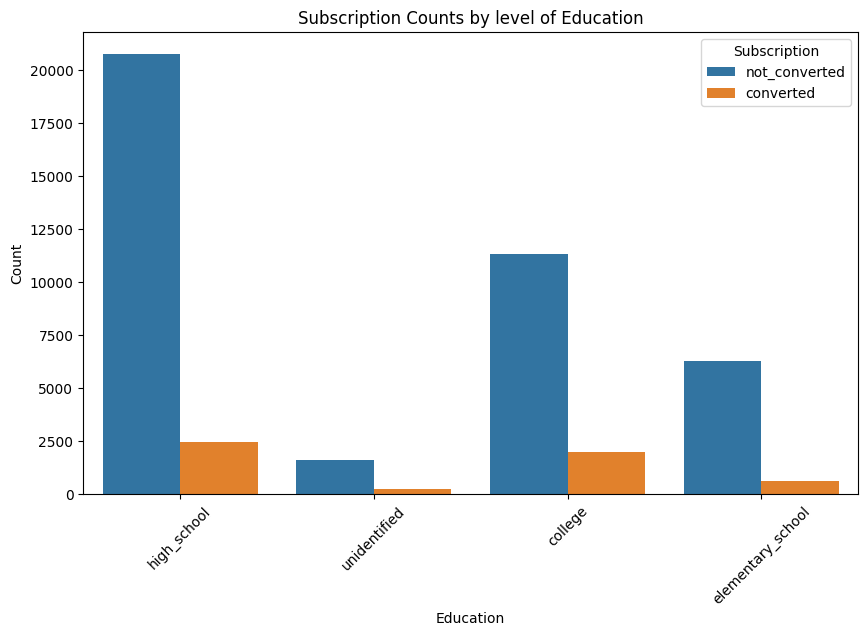

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bank, x='education_level', hue='conversion_status',palette=sns.color_palette())
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Subscription Counts by level of Education')
plt.xticks(rotation=45)
plt.legend(title='Subscription')
plt.show()

<ipython-input-24-bb5912b831a1>:2: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(data=bank, x='previous_campaign_outcome', hue='conversion_status',palette=sns.color_palette())


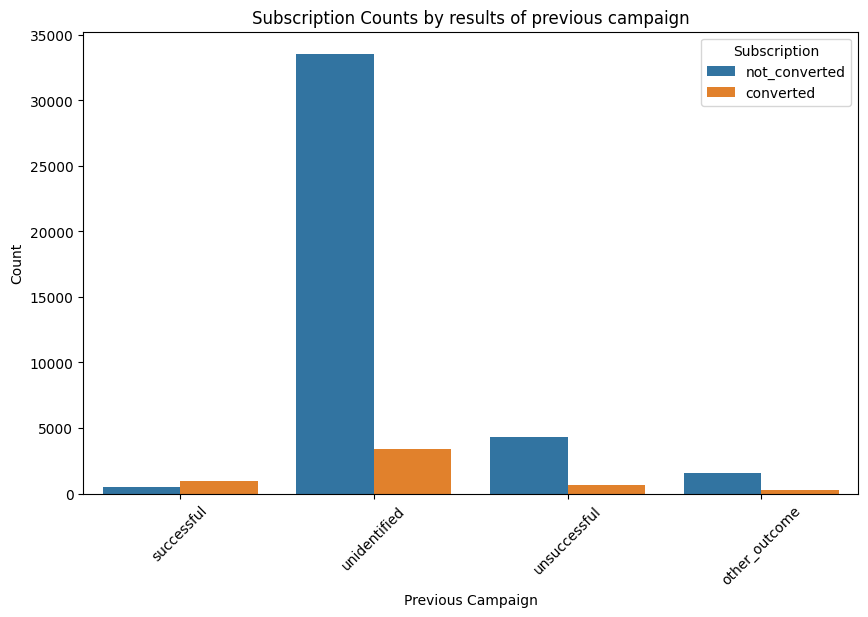

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=bank, x='previous_campaign_outcome', hue='conversion_status',palette=sns.color_palette())
plt.xlabel('Previous Campaign')
plt.ylabel('Count')
plt.title('Subscription Counts by results of previous campaign')
plt.xticks(rotation=45)
plt.legend(title='Subscription')
plt.show()

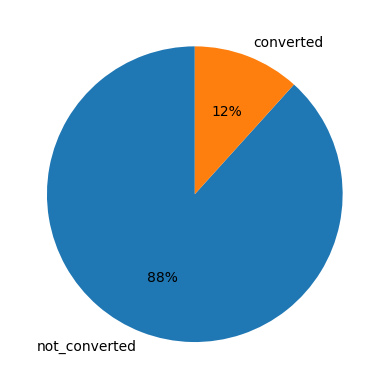

In [ ]:
data = bank.conversion_status.value_counts()
plt.pie(data, labels=data.index, autopct='%0.0f%%', startangle=90,)
plt.show()

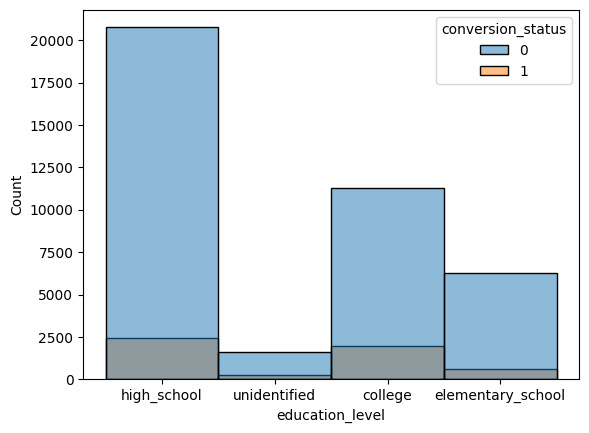

In [ ]:
sns.histplot(bank, x='education_level', hue='conversion_status')
plt.show()

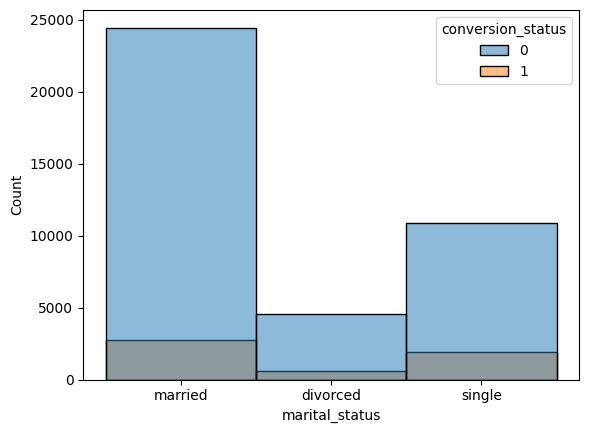

In [ ]:
sns.histplot(bank, x='marital_status', hue='conversion_status')
plt.show()

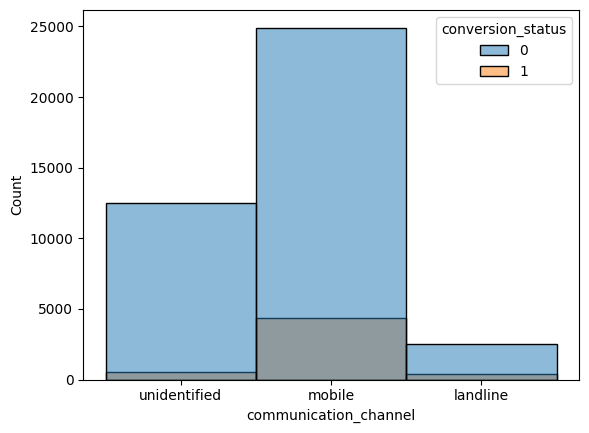

In [ ]:
sns.histplot(bank, x='communication_channel', hue='conversion_status')
plt.show()

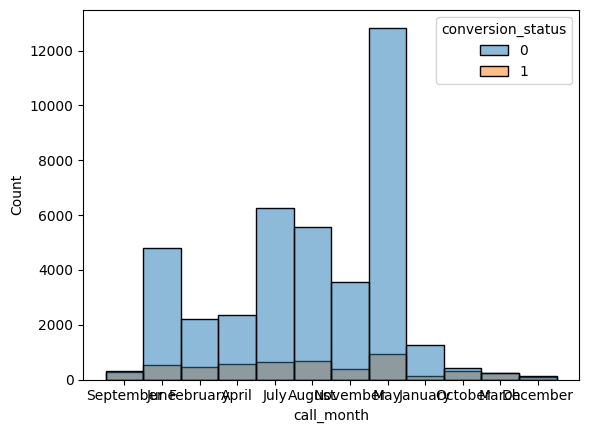

In [ ]:
sns.histplot(bank, x='call_month', hue='conversion_status')
plt.show()

2. After some understanding of the data, let's try to build prediction with XGBoost model.

In [ ]:
cat_columns = bank.select_dtypes(include='object').columns.tolist()
cat_columns = cat_columns[:-1]

In [ ]:
cat_columns

['occupation',
 'education_level',
 'marital_status',
 'communication_channel',
 'call_month',
 'previous_campaign_outcome']

In [ ]:
num_columns = bank.select_dtypes(exclude='object').columns.tolist()
num_columns

['age', 'call_day', 'call_duration', 'call_frequency']

In [ ]:
#Use LabelEncoder for categorical columns
label_encoders = {}

for col in cat_columns:
    le = LabelEncoder()
    bank[col] = le.fit_transform(bank[col])
    label_encoders[col] = le

In [ ]:
bank = bank.replace({'not_converted': 0, 'converted':1})

In [ ]:
bank.head()

,occupation,age,education_level,marital_status,communication_channel,call_month,call_day,call_duration,call_frequency,previous_campaign_outcome,conversion_status
0,0,28,2,1,2,11,9,1,1,1,not_converted
1,0,58,3,1,2,6,5,307,2,2,not_converted
2,5,40,2,0,1,3,4,113,1,2,not_converted
3,7,63,2,1,1,0,7,72,5,2,not_converted
4,1,43,0,1,0,5,29,184,4,2,not_converted


In [ ]:
#Creating training and testing datasets
X = bank.drop('conversion_status', axis=1)
y = bank['conversion_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#Use Scaler for all our numerical columns
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((31643, 10), (13562, 10))

In [ ]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(subsample=0.7, n_estimators=200, max_depth=6, learning_rate=0.1, gamma=6)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9079044388733225
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11997
           1       0.65      0.44      0.52      1565

    accuracy                           0.91     13562
   macro avg       0.79      0.70      0.74     13562
weighted avg       0.90      0.91      0.90     13562



In [ ]:
#Show the feature importance of the model
feature_names = X.columns.tolist()

for name, importance in zip(feature_names, xgb_model.feature_importances_):
    print(f"{name}: {importance:.4f}")

occupation: 0.0317
age: 0.0747
education_level: 0.0440
marital_status: 0.0407
communication_channel: 0.1347
call_month: 0.0758
call_day: 0.0530
call_duration: 0.2566
call_frequency: 0.0490
previous_campaign_outcome: 0.2399


To evaluate results more correctly we need to create ROC curve

In [ ]:
r_probs = [0 for _ in range(len(y_test))]
xgb_probs = xgb_model.predict_proba(X_test)

In [ ]:
xgb_probs = xgb_probs[:, 1]

In [ ]:
r_auc = roc_auc_score(y_test, r_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
print("Random (chance) Prediction: AUROC = %.3f" %(r_auc))
print("XGBoost : AUROC = %.3f" %(xgb_auc))

Random (chance) Prediction: AUROC = 0.500
XGBoost : AUROC = 0.926


In [ ]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

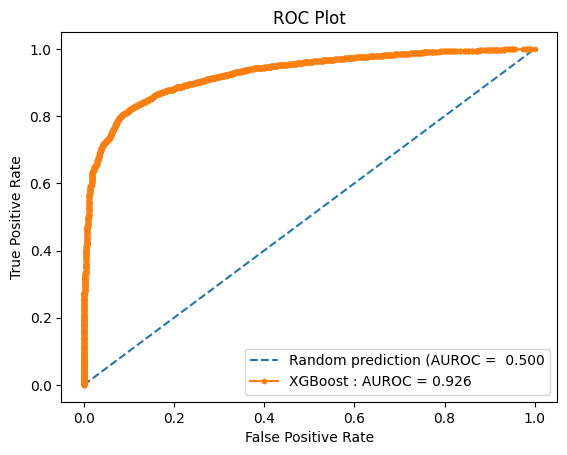

In [ ]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC =  %.3f' %(r_auc))
plt.plot(xgb_fpr, xgb_tpr, marker='.', label="XGBoost : AUROC = %.3f" %(xgb_auc))

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [ ]:
xgb_fpr.dtype

dtype('float64')

In [ ]:
print('r_fpr', r_fpr,  'r_tpr', r_tpr)
print("xgb_fpr", xgb_fpr, "xgb_tpr", xgb_tpr)

In [ ]:
r_roc = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr})

In [ ]:
xgb_roc = pd.DataFrame({'xgb_fpr': xgb_fpr, 'xgb_tpr': xgb_tpr})

In [ ]:
xgb_roc.to_csv('/content/xgb_roc.csv')
r_roc.to_csv('/content/r_roc.csv')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
gbm_param_grid = {
    'learning_rate': np.arange(0.05, 1.05, .05),
    'n_estimators': [200],
    'subsample': np.arange(0.05, 1.05, .05),
    'max_depth': np.arange(2, 20, 1),
    'gamma': np.arange(0, 10, 1)
}

cv_result = RandomizedSearchCV(estimator=xgb_model, param_distributions=gbm_param_grid, n_iter=25, cv=4, verbose=1)
cv_result.fit(X, y)
print('Best parameters found: ', cv_result.best_params_)
print("result: ", cv_result.best_score_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits
Best parameters found:  {'subsample': 0.7500000000000001, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3, 'gamma': 3}
result:  0.9068245249037254


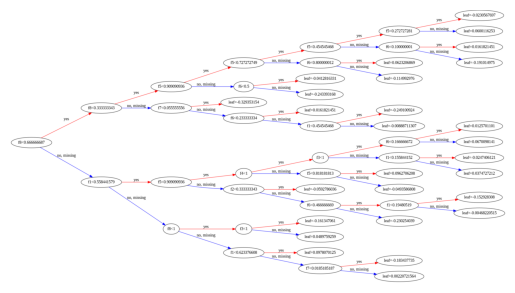

In [ ]:
xgb.plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.savefig('tree.png')

In [ ]:
importance = xgb_model.feature_importances_
featureNames = X.columns

for feature, importance_score in zip(featureNames, importance):
    print(feature, ":", importance_score)

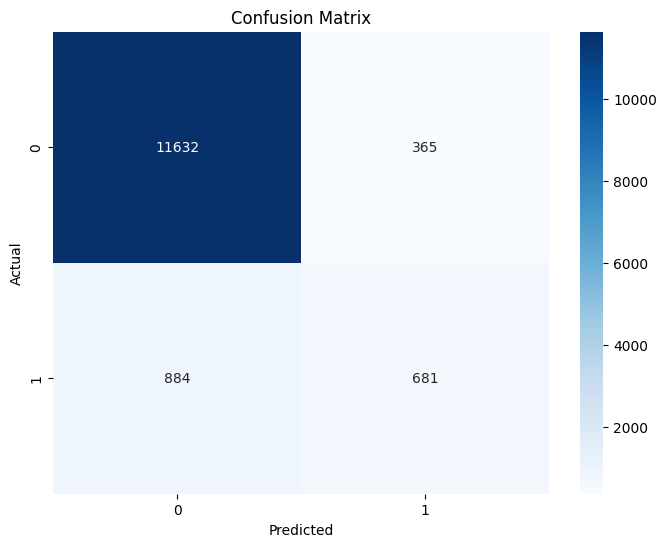

In [ ]:
y_test_predict = xgb_model.predict(X_test)

cm = confusion_matrix(y_test, y_test_predict)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [ ]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

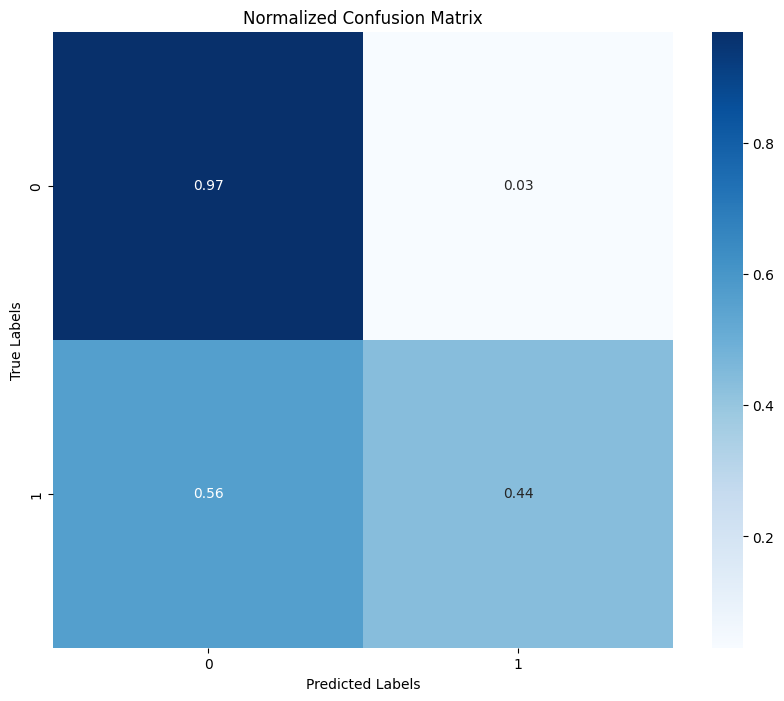

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()